In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os,gc,re,time
import matplotlib.pyplot as plt
import seaborn as sns
import spacy,random
import re,unicodedata
from collections import Counter
import warnings,unicodedata
import math
import torch.optim as optim
from spacy.tokenizer import Tokenizer
from torch.utils.data import TensorDataset, DataLoader
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
from nltk.translate.bleu_score import corpus_bleu
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

warnings.simplefilter("ignore")

In [2]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm

# preprocess

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train_path_en = "/content/drive/MyDrive/Colab Notebooks/multi30k/train/train.lc.norm.tok.en.txt"
train_path_de = "/content/drive/MyDrive/Colab Notebooks/multi30k/train/train.lc.norm.tok.de.txt"
test_path_en = "/content/drive/MyDrive/Colab Notebooks/multi30k/test/test_2017_flickr.lc.norm.tok.en.txt"
test_path_de = "/content/drive/MyDrive/Colab Notebooks/multi30k/test/test_2017_flickr.lc.norm.tok.de.txt"

In [6]:
with open(train_path_en) as en_raw_train:
    en_parsed_train = en_raw_train.readlines()
with open(train_path_de) as de_raw_train:
    de_parsed_train = de_raw_train.readlines()
with open(test_path_en) as en_raw_test:
    en_parsed_test = en_raw_test.readlines()
with open(test_path_de) as de_raw_test:
    de_parsed_test = de_raw_test.readlines()

In [46]:
for i in range(3):
    print("English: {} \n German: {} \n".format(en_parsed_train[i].strip(), de_parsed_train[i].strip()))

English: two young , white males are outside near many bushes . 
 German: zwei junge weiße männer sind im freien in der nähe vieler büsche . 

English: several men in hard hats are operating a giant pulley system . 
 German: mehrere männer mit schutzhelmen bedienen ein antriebsradsystem . 

English: a little girl climbing into a wooden playhouse . 
 German: ein kleines mädchen klettert in ein spielhaus aus holz . 



In [7]:
en_train = [sent.strip().split(" ") for sent in en_parsed_train]
en_test = [sent.strip().split(" ") for sent in en_parsed_test]
de_train = [sent.strip().split(" ") for sent in de_parsed_train]
de_test = [sent.strip().split(" ") for sent in de_parsed_test]

In [8]:
en_index2word = ["<UNK>", "<PAD>", "<SOS>", "<EOS>"]
de_index2word = ["<UNK>", "<PAD>", "<SOS>", "<EOS>"]

In [9]:
for ds in [en_train, en_test]:
    for sent in ds:
        for token in sent:
            if token not in en_index2word:
                en_index2word.append(token)

for ds in [de_train, de_test]:
    for sent in ds:
        for token in sent:
            if token not in de_index2word:
                de_index2word.append(token)

In [10]:
en_word2index = {token: idx for idx, token in enumerate(en_index2word)}
de_word2index = {token: idx for idx, token in enumerate(de_index2word)}

In [11]:
en_index2word[3]

'<EOS>'

In [12]:
en_word2index["a"]

21

In [13]:
de_index2word[21]

'ein'

In [14]:
seq_length = 20

In [15]:
def build_vocab(vocab, sent, max_length):
    sos = [vocab["<SOS>"]]
    eos = [vocab["<EOS>"]]
    pad = [vocab["<PAD>"]]

    if len(sent) < max_length - 2: # -2 for SOS and EOS
        n_pads = max_length - 2 - len(sent)
        encoded = [vocab[w] for w in sent]
        return sos + encoded + eos + pad * n_pads
    else: # sent is longer than max_length; truncating
        encoded = [vocab[w] for w in sent]
        truncated = encoded[:max_length - 2]
        return sos + truncated + eos

In [16]:
en_train_dataset = [build_vocab(en_word2index, sent, seq_length) for sent in en_train]
en_test_dataset = [build_vocab(en_word2index, sent, seq_length) for sent in en_test]
de_train_dataset = [build_vocab(de_word2index, sent, seq_length) for sent in de_train]
de_test_dataset = [build_vocab(de_word2index, sent, seq_length) for sent in de_test]

In [17]:
batch_size = 64

train_x = np.array(de_train_dataset)
train_y = np.array(en_train_dataset)
test_x = np.array(de_test_dataset)
test_y = np.array(en_test_dataset)

train_ds = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
test_ds = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

train_loader = DataLoader(train_ds, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_ds, shuffle=True, batch_size=batch_size, drop_last=True)

In [18]:
for batch in train_loader:
    source_batch, target_batch = batch

    print(f"첫 번째 배치 크기: {source_batch.shape}")

    # 현재 배치에 있는 하나의 문장에 포함된 정보 출력
    for i in range(source_batch.shape[1]):
        print(f"인덱스 {i}: {source_batch[0][i].item()}") # 여기에서는 [Seq_num, Seq_len]

    # 첫 번째 배치만 확인
    break

첫 번째 배치 크기: torch.Size([64, 20])
인덱스 0: 2
인덱스 1: 21
인덱스 2: 963
인덱스 3: 95
인덱스 4: 164
인덱스 5: 11
인덱스 6: 12
인덱스 7: 13
인덱스 8: 254
인덱스 9: 8092
인덱스 10: 9
인덱스 11: 302
인덱스 12: 16
인덱스 13: 3
인덱스 14: 1
인덱스 15: 1
인덱스 16: 1
인덱스 17: 1
인덱스 18: 1
인덱스 19: 1


# model

In [19]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, dropout_ratio):
        super().__init__()

        assert hidden_dim % n_heads == 0

        self.hidden_dim = hidden_dim
        self.n_heads = n_heads
        self.head_dim = hidden_dim // n_heads

        self.fc_q = nn.Linear(hidden_dim, hidden_dim)
        self.fc_k = nn.Linear(hidden_dim, hidden_dim)
        self.fc_v = nn.Linear(hidden_dim, hidden_dim)

        self.fc_o = nn.Linear(hidden_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim]))

    def forward(self, query, key, value, mask = None):

        batch_size = query.shape[0]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        if mask is not None:
            energy = energy.masked_fill(mask==0, -1e10)
        attention = torch.softmax(energy, dim=-1)
        x = torch.matmul(self.dropout(attention), V)
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(batch_size, -1, self.hidden_dim)
        x = self.fc_o(x)

        return x, attention

In [20]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hidden_dim, pf_dim, dropout_ratio):
        super().__init__()

        self.fc_1 = nn.Linear(hidden_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, x):

        x = self.dropout(torch.relu(self.fc_1(x)))
        x = self.fc_2(x)

        return x

In [21]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, src, src_mask):

        _src, _ = self.self_attention(src, src, src, src_mask)
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        # position-wise feedforward
        _src = self.positionwise_feedforward(src)

        # dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))

        return src

In [22]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, max_length=100):
        super().__init__()


        self.tok_embedding = nn.Embedding(input_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)

        self.layers = nn.ModuleList([EncoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio) for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim]))

    def forward(self, src, src_mask):

        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1)

        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

        for layer in self.layers:
            src = layer(src, src_mask)

        return src

In [23]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio)
        self.encoder_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

        # positionwise feedforward
        _trg = self.positionwise_feedforward(trg)

        # dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        return trg, attention

In [24]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, max_length=100):
        super().__init__()


        self.tok_embedding = nn.Embedding(output_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)

        self.layers = nn.ModuleList([DecoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio) for _ in range(n_layers)])

        self.fc_out = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim]))

    def forward(self, trg, enc_src, trg_mask, src_mask):

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1)

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))

        for layer in self.layers:
            # 소스 마스크와 타겟 마스크 모두 사용
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        output = self.fc_out(trg)

        return output, attention

In [25]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx

    def make_src_mask(self, src):


        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        return src_mask

    # 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크를 사용
    def make_trg_mask(self, trg):

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len))).bool()

        trg_mask = trg_pad_mask & trg_sub_mask

        return trg_mask

    def forward(self, src, trg):

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        enc_src = self.encoder(src, src_mask)

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        return output, attention

In [26]:
INPUT_DIM = len(de_word2index)
OUTPUT_DIM = len(en_word2index)

HIDDEN_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

In [27]:
SRC_PAD_IDX = de_word2index['<PAD>']
TRG_PAD_IDX = en_word2index['<PAD>']

In [28]:
enc = Encoder(INPUT_DIM, HIDDEN_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, HIDDEN_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT)

# Transformer 객체 선언
model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX)

In [29]:
model

Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(19139, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
    

# train

In [30]:
LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [31]:
def train(model, train_loader, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0

    for batch in train_loader:
        src, trg = batch

        optimizer.zero_grad()

        output, _ = model(src, trg[:,:-1])

        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)

        trg = trg[:,1:].contiguous().view(-1)

        loss = criterion(output, trg)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        del src, trg

        epoch_loss += loss.item()

    return epoch_loss / len(train_loader)

In [32]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [33]:
N_EPOCHS = 10
CLIP = 1
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, CLIP)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):.3f}')

Epoch: 01 | Time: 2m 8s
	Train Loss: 3.948 | Train PPL: 51.821
Epoch: 02 | Time: 2m 3s
	Train Loss: 2.898 | Train PPL: 18.145
Epoch: 03 | Time: 2m 3s
	Train Loss: 2.482 | Train PPL: 11.960
Epoch: 04 | Time: 2m 1s
	Train Loss: 2.189 | Train PPL: 8.925
Epoch: 05 | Time: 1m 59s
	Train Loss: 1.955 | Train PPL: 7.064
Epoch: 06 | Time: 2m 0s
	Train Loss: 1.762 | Train PPL: 5.822
Epoch: 07 | Time: 2m 0s
	Train Loss: 1.596 | Train PPL: 4.935
Epoch: 08 | Time: 1m 59s
	Train Loss: 1.453 | Train PPL: 4.278
Epoch: 09 | Time: 1m 57s
	Train Loss: 1.332 | Train PPL: 3.789
Epoch: 10 | Time: 1m 59s
	Train Loss: 1.228 | Train PPL: 3.413


# translate

In [34]:
def translate_sentence(sentence, de_word2index, en_word2index, model, max_len=30, logging=True):
    model.eval()

    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # 처음에  토큰, 마지막에  토큰 붙이기
    tokens = ['<SOS>'] + tokens + ['<EOS>']
    if logging:
        print(f"전체 소스 토큰: {tokens}")

    src_indexes = [de_word2index.get(token, de_word2index['<UNK>']) for token in tokens]
    if logging:
        print(f"소스 문장 인덱스: {src_indexes}")

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0)

    # 소스 문장에 따른 마스크 생성
    src_mask = model.make_src_mask(src_tensor)

    # 인코더(endocer)에 소스 문장을 넣어 출력 값 구하기
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    # 처음에는 토큰 하나만
    trg_indexes = [en_word2index['<SOS>']]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0)

        # 출력 문장에 따른 마스크 생성
        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        # 출력 문장에서 가장 마지막 단어만 사용
        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token)

        if pred_token == en_word2index['<EOS>']:
            break

    # 각 출력 단어 인덱스를 실제 단어로 변환
    trg_tokens = [en_index2word[i] for i in trg_indexes]

    # 첫 번째는 제외하고 출력 문장 반환
    return trg_tokens[1:], attention

In [35]:
def load_and_preprocess_data(en_path, de_path):

    spacy_en = spacy.load('en_core_web_sm')
    spacy_de = spacy.load('de_core_news_sm')

    with open(en_path) as en_raw_test:
        en_parsed_test = en_raw_test.readlines()
    with open(de_path) as de_raw_test:
        de_parsed_test = de_raw_test.readlines()

    en_tokenized = [tokenize_en(line, spacy_en) for line in en_parsed_test]
    de_tokenized = [tokenize_de(line, spacy_de) for line in de_parsed_test]

    test_df = pd.DataFrame({'en': en_tokenized, 'de': de_tokenized})

    return test_df

In [37]:
def tokenize_de(text, spacy_model):
    return [token.text for token in spacy_model(text)]

def tokenize_en(text, spacy_model):
    return [token.text for token in spacy_model(text)]

In [38]:
test = load_and_preprocess_data(test_path_en, test_path_de)

In [39]:
test['de'][3]

['ein',
 'mann',
 'mit',
 'nackter',
 'brust',
 'schreit',
 'bei',
 'einem',
 'auftritt',
 'auf',
 'einer',
 'bühne',
 'einen',
 'song',
 'heraus',
 '.',
 '\n']

In [40]:
class CustomTestData:
    def __init__(self, data):
        self.data = data

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)

test_data_de = CustomTestData(test['de'])
test_data_en = CustomTestData(test['en'])

example_idx = 10

src = test_data_de[example_idx]
trg = test_data_en[example_idx]

print(src)
print(trg)

translation, attention = translate_sentence(src, de_word2index, en_word2index, model, logging=True)

print("모델 출력 결과:", " ".join(translation))

['ein', 'junger', 'mann', 'macht', 'auf', 'einem', 'skateboard', 'ein', 'kunststück', 'in', 'der', 'luft', '.', '\n']
['a', 'young', 'man', 'performs', 'an', 'aerial', 'stunt', 'on', 'a', 'skateboard', '.', '\n']
전체 소스 토큰: ['<SOS>', 'ein', 'junger', 'mann', 'macht', 'auf', 'einem', 'skateboard', 'ein', 'kunststück', 'in', 'der', 'luft', '.', '\n', '<EOS>']
소스 문장 인덱스: [2, 21, 180, 29, 270, 34, 30, 420, 21, 581, 11, 12, 725, 16, 0, 3]
모델 출력 결과: a young man is doing a trick on a skateboard in the air . <EOS>


In [41]:
def display_attention(sentence, translation, attention, n_heads=8, n_rows=4, n_cols=2):

    assert n_rows * n_cols == n_heads

    fig = plt.figure(figsize=(10, 15))

    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)

        # 어텐션(Attention) 스코어 확률 값을 이용해 그리기
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels([''] + [''] + [t.lower() for t in sentence] + [''], rotation=45)
        ax.set_yticklabels([''] + translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

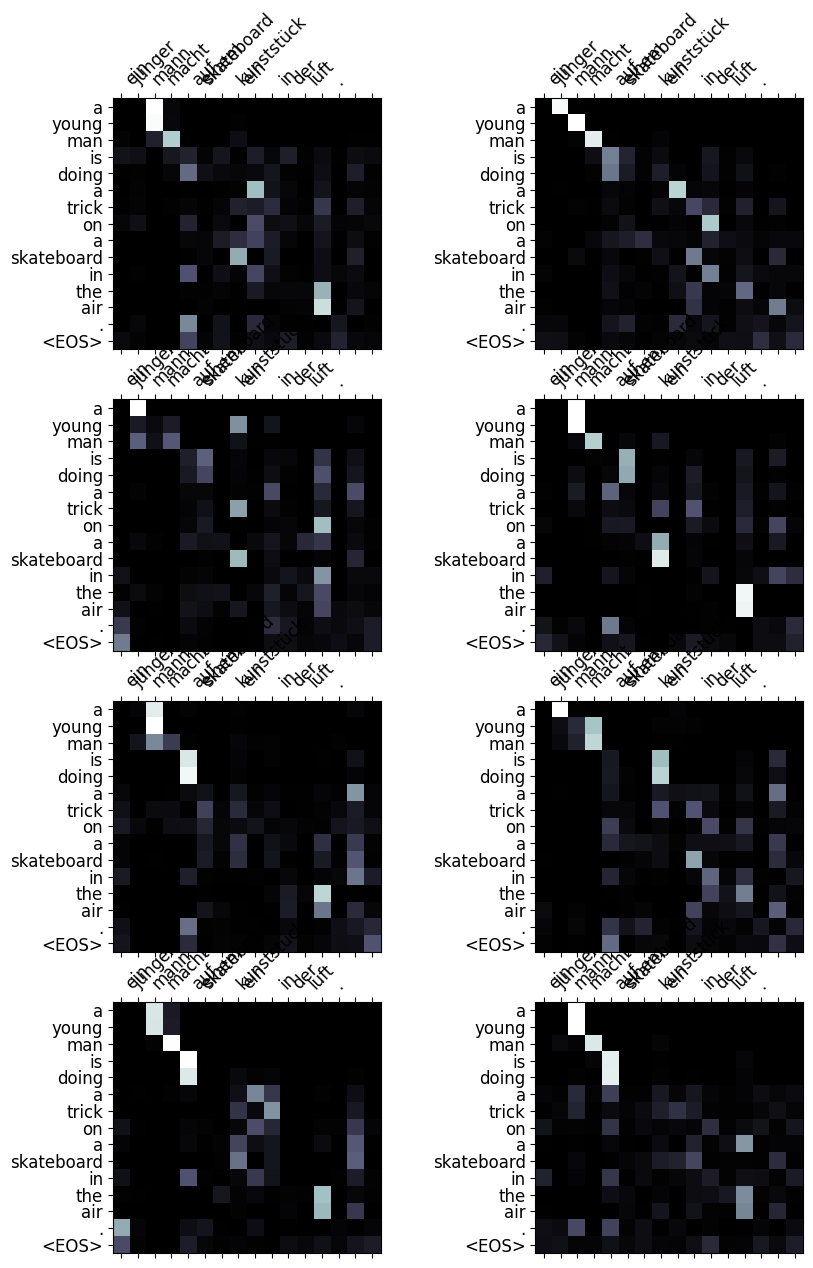

In [42]:
display_attention(src, translation, attention)

In [43]:
def show_bleu(data, de_word2index, en_word2index, model, max_len=50):
    trgs = []
    pred_trgs = []
    index = 0

    smoothing = SmoothingFunction()

    for example_idx in range(1, 1000):
        src = test_data_de[example_idx]
        trg = test_data_en[example_idx]

        pred_trg, _ = translate_sentence(src, de_word2index, en_word2index, model, max_len, logging=False)

        # 마지막 토큰 제거
        pred_trg = pred_trg[:-1]

        pred_trgs.append(pred_trg)
        trgs.append([trg])

        index += 1
        if (index + 1) % 100 == 0:
            print(f"[{index + 1}/{len(data)}]")
            print(f"예측: {pred_trg}")
            print(f"정답: {trg}")

    # Calculate BLEU-4 score
    bleu_scores = []
    for i in range(len(trgs)):
        bleu = sentence_bleu(trgs[i], pred_trgs[i], weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing.method0)
        bleu_scores.append(bleu)

    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    print(f'Average BLEU-4 Score = {avg_bleu*100:.2f}')

In [44]:
show_bleu(test_data_de, de_word2index, en_word2index, model)

[100/1000]
예측: ['a', 'train', 'car', 'is', 'going', 'through', 'the', 'snow', '.']
정답: ['a', 'train', 'is', 'moving', 'on', 'tracks', 'next', 'to', 'some', 'snow', '.', '\n']
[200/1000]
예측: ['man', 'with', 'a', 'bicycle', 'selling', 'decals', 'on', 'the', 'street', '.']
정답: ['a', 'man', 'with', 'his', 'bicycle', 'selling', 'his', 'products', 'on', 'a', 'street', '\n']
[300/1000]
예측: ['the', 'duck', 'is', 'poking', 'boulders', 'the', 'water', 'on', 'the', 'wet', 'concrete', 'slab', '.']
정답: ['the', 'duck', 'flaps', 'its', 'wings', 'on', 'the', 'wet', 'rocks', 'by', 'the', 'water', '.', '\n']
[400/1000]
예측: ['numerous', 'women', 'with', 'american', 'flags', 'standing', 'in', 'front', 'of', 'a', 'building', '.']
정답: ['numerous', 'women', 'wearing', 'fur', 'coats', 'are', 'standing', 'outside', 'a', 'building', '.', '\n']
[500/1000]
예측: ['a', 'soccer', 'player', 'tries', 'to', 'reach', 'the', 'ball', 'with', 'a', 'ball', 'that', 'is', 'trying', 'to', 'reach', 'the', 'ball']
정답: ['a', 'socc